<h1>Popular Steam Game Sentiment Analysis</h1>
Citation </br>
Antoni Sobkowicz. (2017). Steam Review Dataset (2017) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1000885

License
CC BY NC 4.0|

# 1. Install & Import Necessary Libray For NLP and Sentiment Analysis

In [1]:
# %pip install stopwords
# %pip install flair
# %pip install nltk
# %pip install swifter
# %pip install wordcloud
# %pip install pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
# nltk.download()

from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random as rn
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
pd.options.display.max_rows = None

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
# from scikitplot.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# 2. Import Steam Games Review Dataset

app_id       -> Game ID <br/>
app_name     -> Game Name <br/>
review_text  -> Review text <br/>
review_score -> Review Sentiment: whether the game the review recommends the game or not. [1: Yes, -1: No, 0: None] <br/>
review_votes -> Review vote  : whether the review was recommended by another user or not. [1: Yes, 0: No] <br/>

In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [5]:
# Since the dataset contains 6.4m data, I planned to 
# scale down the dataset to <100,000 entries.

# Check the amount of review from rach game
df['app_name'].value_counts(ascending=False, dropna=True).head()

PAYDAY 2    88973
DayZ        88850
Terraria    84828
Rust        77037
Dota 2      73541
Name: app_name, dtype: int64

In [6]:
# Since Dota 2 has the most review and contains 88973 entries, 
# I decided to make sentiment analysis on the chosen game - PAYDAY 2.

#Create payday2 dataframe
dota2_df = df[df['app_name'] == 'Dota 2'].reset_index(drop=True)
dota2_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,570,Dota 2,"Causes anxiety problems, low self esteem, Tour...",1,1
1,570,Dota 2,This game taught me about the diversity of cul...,1,0
2,570,Dota 2,It's like roulette; fun until it turns into Ru...,1,0
3,570,Dota 2,"In Dota 2, Not many people speak your languag...",1,0
4,570,Dota 2,Side effects include: -Explosive diarrhea -Ha...,1,0


In [7]:
# Generate dota2_dataset.csv file that help to load faster in further use
dota2_df.to_csv('dota2_dataset.csv', index=False)

## Load payday2_dataset.csv dataset

In [8]:
dota2_df = pd.read_csv('dota2_dataset.csv')
dota2_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,570,Dota 2,"Causes anxiety problems, low self esteem, Tour...",1,1
1,570,Dota 2,This game taught me about the diversity of cul...,1,0
2,570,Dota 2,It's like roulette; fun until it turns into Ru...,1,0
3,570,Dota 2,"In Dota 2, Not many people speak your languag...",1,0
4,570,Dota 2,Side effects include: -Explosive diarrhea -Ha...,1,0


In [9]:
dota2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73541 entries, 0 to 73540
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   app_id        73541 non-null  int64 
 1   app_name      73541 non-null  object
 2   review_text   73433 non-null  object
 3   review_score  73541 non-null  int64 
 4   review_votes  73541 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


In [10]:
dota2_df['review_text'] = dota2_df['review_text'].astype('str')

# 3. EDA (Analysis and Visualization)

## Distribution of Reviews in Each Sentiment

In [11]:
temp = dota2_df.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text',ascending=False)
temp.style.background_gradient(cmap='ocean')

,review_score,review_text
1,1,62923
0,-1,10618


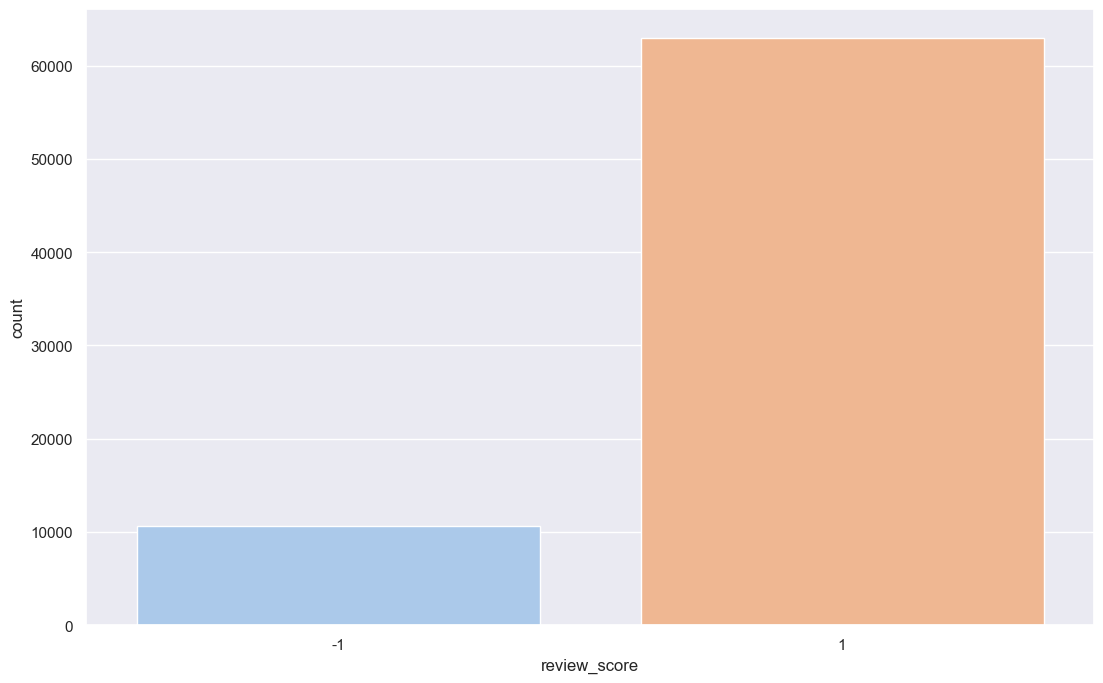

In [12]:
# We will see the visualization of it.
sns.set_theme(style='whitegrid')
sns.set(rc = {'figure.figsize':(13,8)})
sns.set_palette("pastel")
sns.countplot(x='review_score',data=dota2_df);

### Conclude: Amount of Positive > Negative
We can see that there are more positive sentiment reviews than negative sentiment reviews.

## WordCloud of Our Review Text

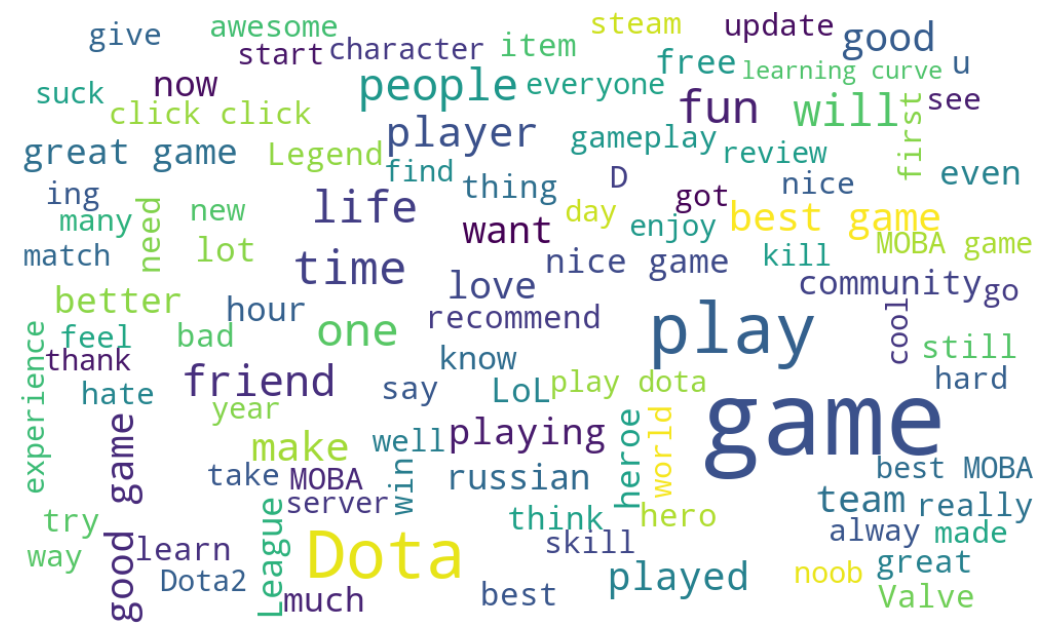

In [13]:
txt = ' '.join(rev for rev in dota2_df.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### WordCloud of Each Sentiment Review Text

In [14]:
positive = dota2_df[dota2_df['review_score']==1]
negative = dota2_df[dota2_df['review_score']==-1]

#### Positive Sentiment Reviews

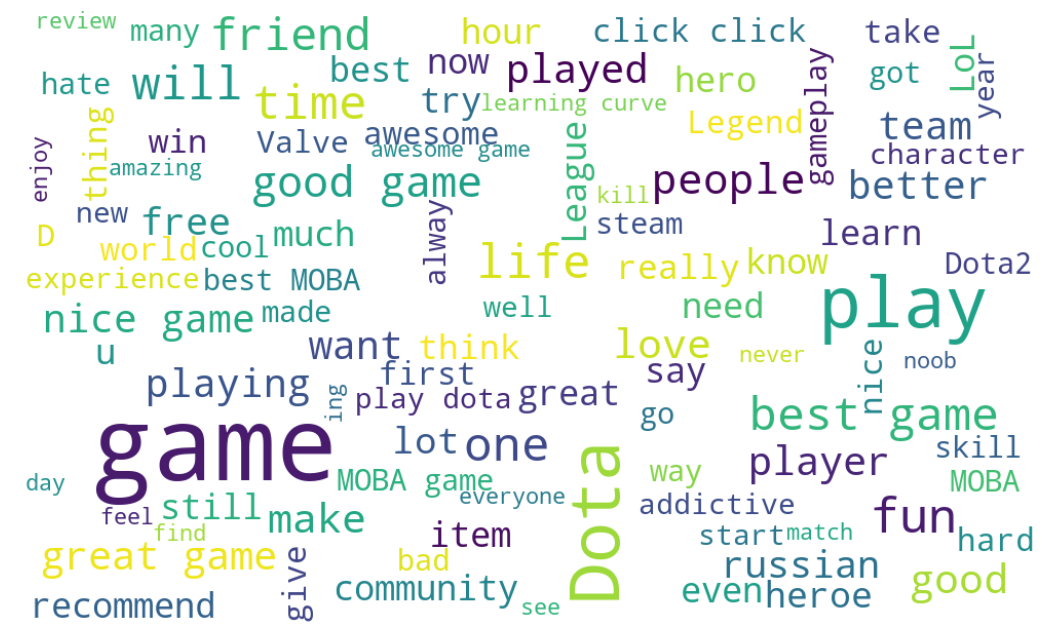

In [15]:
# Positive Sentiment Reviews
txt = ' '.join(rev for rev in positive.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

We can see that for postive sentiment review, the most common words are 'good', 'great', 'nice', 'best', etc as shown in picture above.

#### Negative Sentiment Reviews

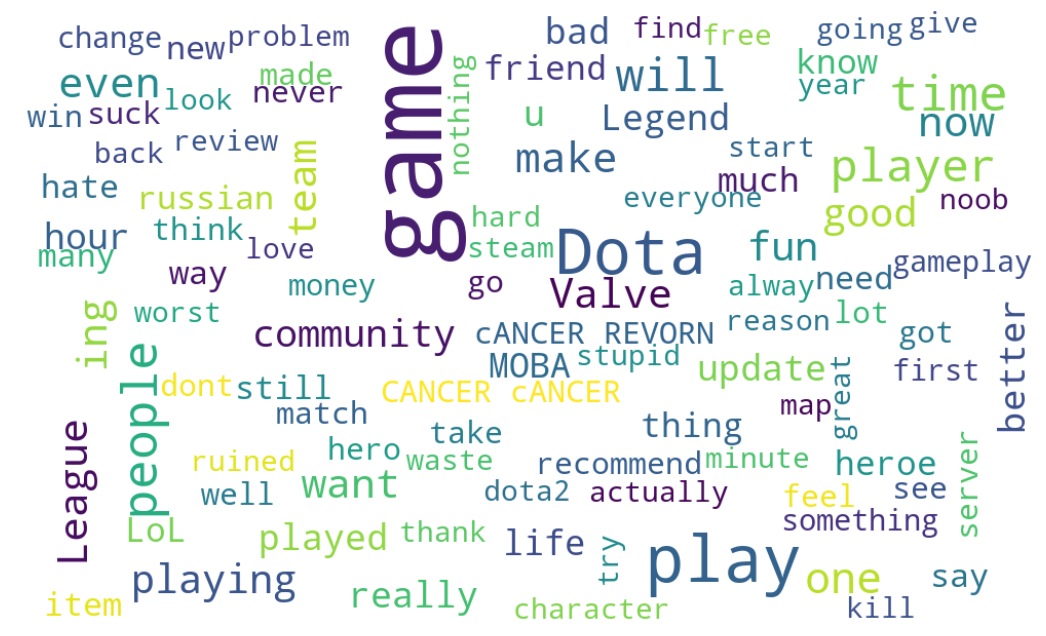

In [16]:
txt = ' '.join(rev for rev in negative.review_text)
plt.figure(figsize=(15,8))

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

And we can see that for negative sentiment review, the most common words are 'suck', 'Cancer', 'bad' etc as shown in picture above. 

## Distribution of Number of Review Words

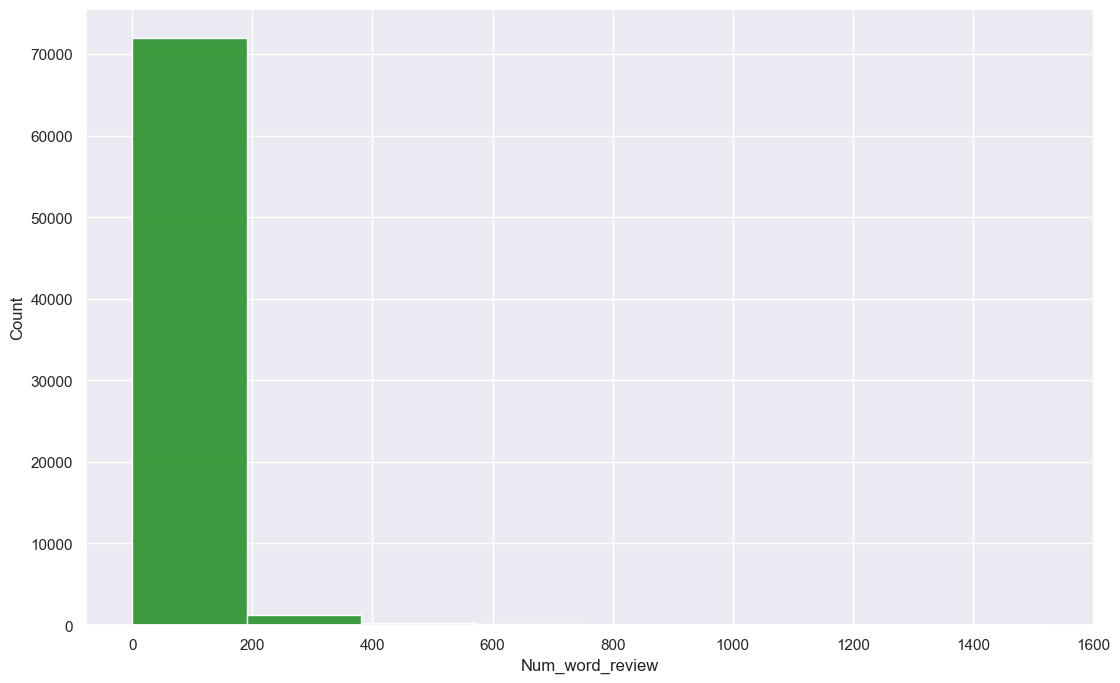

In [20]:
review_vis = dota2_df.copy()
review_vis['Num_word_review'] = review_vis['review_text'].apply(lambda x:len(str(x).split()))

sns.histplot(data=review_vis, x="Num_word_review",bins=8,color='green');

### Observation on Result
As we can see that most of our review texts contain 1-200 words.

## Distribution of Words in All Review Texts

In [21]:
review_vis['temp_list'] = review_vis['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,58529
1,to,48303
2,and,48106
3,game,46195
4,a,39781
5,of,35987
6,is,35889
7,you,32438
8,this,26902
9,I,26900


### Conclude on Observation
Of course this list still contains stopwords which we have not filtered yet. We will see them later after we filter our review texts.

# 4. Data Cleaning For Sentiment Processing

In [22]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Basic Cleaning
### Remove Null values 

In [23]:
dota2_df.isnull().sum()

app_id          0
app_name        0
review_text     0
review_score    0
review_votes    0
dtype: int64

### Remove Duplicate Values

In [24]:
review = dota2_df.drop_duplicates(keep='first')

In [25]:
review.shape

(50190, 5)

## Enhanced Cleaning

#### Remove hyperlinks and markup

In [26]:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

#### Remove Numeric

In [27]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

#### Remove Emoji

In [28]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

#### Remove Symbols

In [29]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

#### Remove Punctuation

In [30]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

#### Remove Stopwords

In [31]:
stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

#### Unify Whitespaces

In [32]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

#### Normalize words using Stemming

In [33]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
def Stemming(text):
   stem=[]
   stopword = stopwords.words('english')
   snowball_stemmer = SnowballStemmer('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [34]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(Stemming)

cleaning(review,'review_text')
review[['review_text']].head(20)

,review_text
0,caus anxieti problem low self esteem tourett s...
1,game taught divers cultur small littl corner u...
2,like roulett fun turn russian
3,dota mani peopl speak languag mani peopl play ...
4,side effect includ explos diarrhea hatr human ...
5,hour fun select russia want play today
6,game murder tree kill ancient creatur chill ca...
7,dota start game ruin social life spend everi d...
8,play game thought brazillian bad soccer
9,game made racist toward speak languag english ...


## Conclude: After Cleaning
 Now all the cleanings are done. We will try to visualize the common words distribution of our review texts. We have done it before but our previous review texts still contain stopwords and punctuations.

In [35]:
review_vis2 = review.copy()
review_vis2['temp_list'] = review_vis2['review_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')


,Common_words,count
0,game,54203
1,play,24024
2,dota,16408
3,like,8404
4,good,7974
5,get,7399
6,best,6550
7,time,6058
8,fun,5477
9,player,5233


<AxesSubplot:xlabel='count', ylabel='Common_words'>

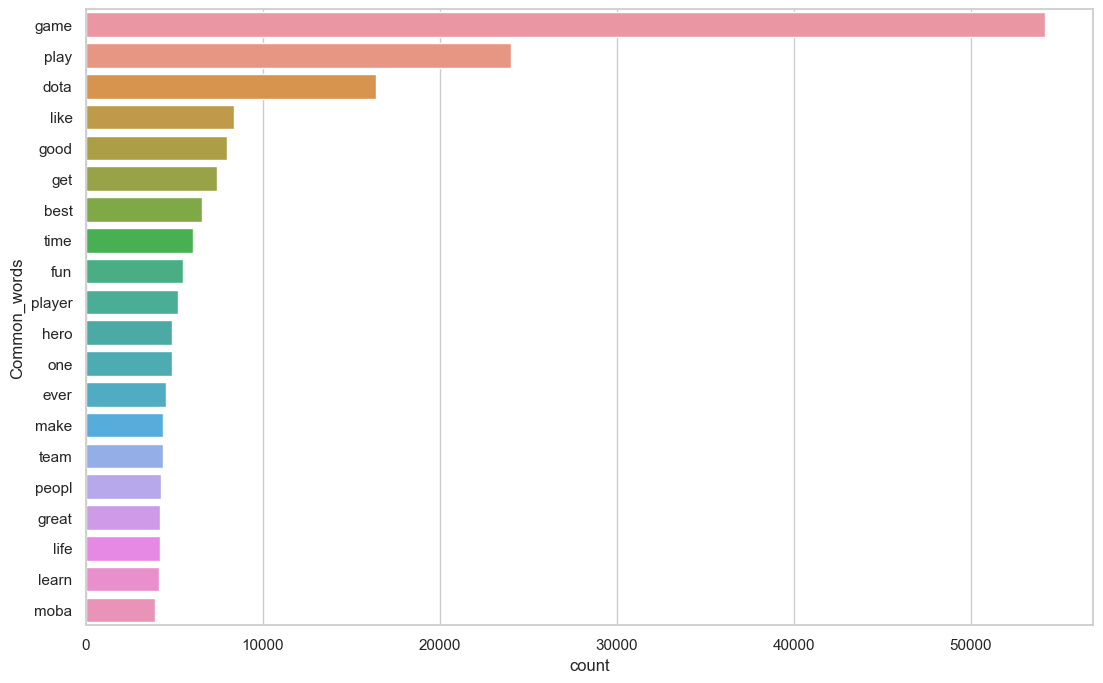

In [36]:
sns.set_theme(style="whitegrid")
sns.barplot(x="count", y="Common_words", data=temp)

# 5. Creating Bag of Words and Text Classifier Model
## Creating pipeline for tokenizing and modelling (Base Model)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=4000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

In [38]:
X = review['review_text']
y = review['review_score']

In [39]:
from collections import Counter
Counter(y)

Counter({1: 42369, -1: 7821})

## Tokenizing and Model Training

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 23, test_size = 0.2)

In [44]:
base_classifier = clf.fit(X_train,y_train)

In [45]:
predictions = base_classifier.predict(X_test)

In [46]:
np.unique(predictions)

array([-1,  1], dtype=int64)

## Test Model's Performance (Base Model)

In [47]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, roc_auc_score
confusion_matrix(y_test,predictions)

array([[ 382, 1162],
       [ 190, 8304]], dtype=int64)

In [48]:
def Performance(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred,labels=[1,-1]))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[1,0]))
    print('FN - False Negative {}'.format(cfmat[0,1]))
    print('TP - True Positive {}'.format(cfmat[0,0]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [49]:
Performance(y_test,predictions)

Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.88      0.98      0.92      8494
          -1       0.67      0.25      0.36      1544

    accuracy                           0.87     10038
   macro avg       0.77      0.61      0.64     10038
weighted avg       0.85      0.87      0.84     10038



TN - True Negative 8304
FP - False Positive 190
FN - False Negative 1162
TP - True Positive 382
Accuracy Rate: 0.8653118151026101
Misclassification Rate: 0.13468818489738993
F1-Score: 0.6428901023488449
ROC-AUC 0.6125202977780109


<AxesSubplot:>

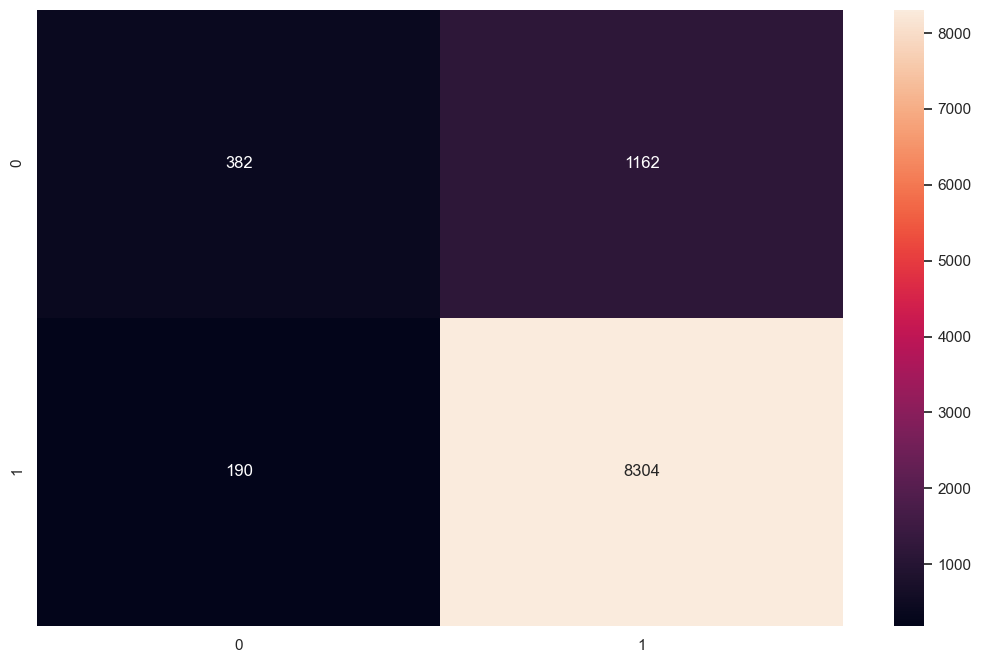

In [50]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='')

We see from above confusion matrix that our model has accuracy of 86.5 % and F1-Score of 0.64. It is not good because our data is highly imbalanced. Our model has high accuracy because it computes accuracy of prediction on majority class. After putting our attention to F1-Score, we can understand that our data is poorly at predicting negative class. 

We also have ROC-AUC score of 0.61. So there is a high chance that the our text classifier model WILL NOT be able to distinguish the positive sentiment class values from the negative sentiment class values.

## Imbalanced Data Classes Handling

In [51]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

Tweet Sentiment Class Proportion after oversampling and undersampling: 
 Counter({-1: 35000, 1: 35000})
Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.98      0.90      0.94      8494
          -1       0.62      0.89      0.73      1544

    accuracy                           0.90     10038
   macro avg       0.80      0.89      0.83     10038
weighted avg       0.92      0.90      0.90     10038



TN - True Negative 7633
FP - False Positive 861
FN - False Negative 168
TP - True Positive 1376
Accuracy Rate: 0.897489539748954
Misclassification Rate: 0.10251046025104603
F1-Score: 0.8323507851104491
ROC-AUC 0.8949130199799676


<AxesSubplot:>

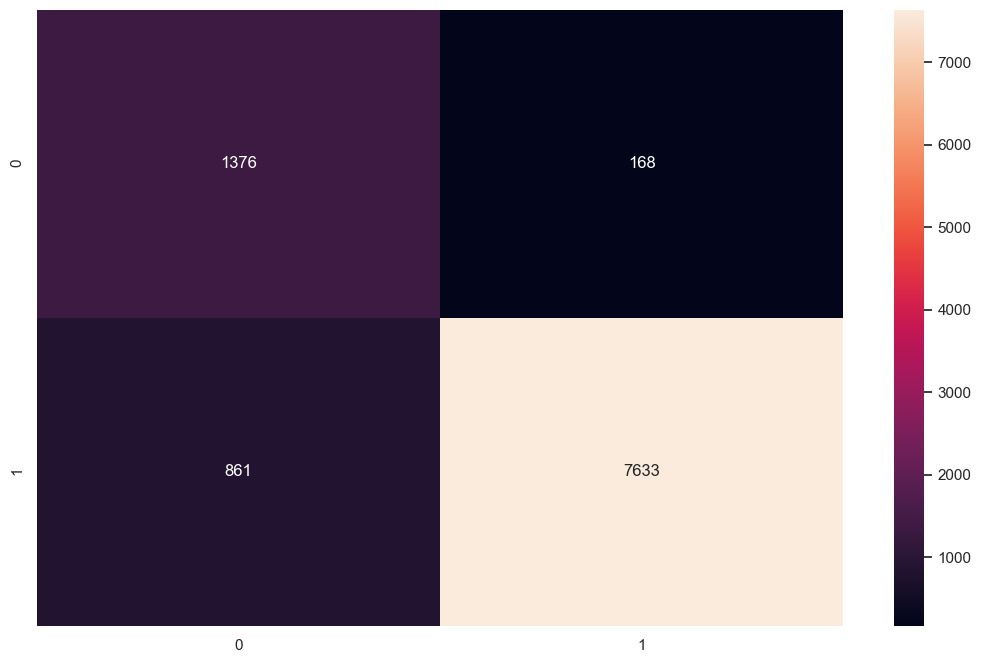

In [52]:
#Then we set our sampling strategy and variables needed in pipeline
strategy1 = {-1: 35000}
strategy2 = {1: 35000}

vect = CountVectorizer(stop_words="english", max_features=3000)
tfidf = TfidfTransformer()
over = SMOTE(sampling_strategy=strategy1)
under = RandomUnderSampler(sampling_strategy=strategy2)
model = RandomForestClassifier()

X = review['review_text'].values
y = review['review_score'].values

trf = vect.fit(X)
X = trf.transform(X)

steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps)

X_new, y_new = pipeline.fit_resample(X, y)
counter_new = Counter(y_new)
print("Tweet Sentiment Class Proportion after oversampling and undersampling: \n",counter_new)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y_new, random_state=23,
                                                        test_size=0.20)

#We prepare our original data(before oversampling and undersampling) as our evaluation data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23,
                                                    test_size=0.20)

# Then we run our pipeline and train the model
pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
])

text_classifier2 = pipeline2.fit(X_train2, y_train2)
# Evaluation on original data
predictions2 = text_classifier2.predict(X_test)
Performance(y_test, predictions2)

sns.heatmap(confusion_matrix(y_test, predictions2), annot=True, fmt='')

Now we got better model after training it on oversampling and undersampling data. We got model with accuracy of 88.7% and F1-Score of 0.83.
We also have ROC-AUC score of 0.9. So there is a high chance that the our text classifier model WILL be able to distinguish the positive sentiment class values from the negative sentiment class values on larger data.

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Confusion Matrix: 
               precision    recall  f1-score   support

           1       0.98      0.92      0.95      8446
          -1       0.67      0.89      0.77      1592

    accuracy                           0.91     10038
   macro avg       0.83      0.90      0.86     10038
weighted avg       0.93      0.91      0.92     10038



TN - True Negative 7755
FP - False Positive 691
FN - False Negative 174
TP - True Positive 1418
Accuracy Rate: 0.9138274556684598
Misclassification Rate: 0.08617254433154015
F1-Score: 0.8567274782346839
ROC-AUC 0.9044448205983742


<AxesSubplot:>

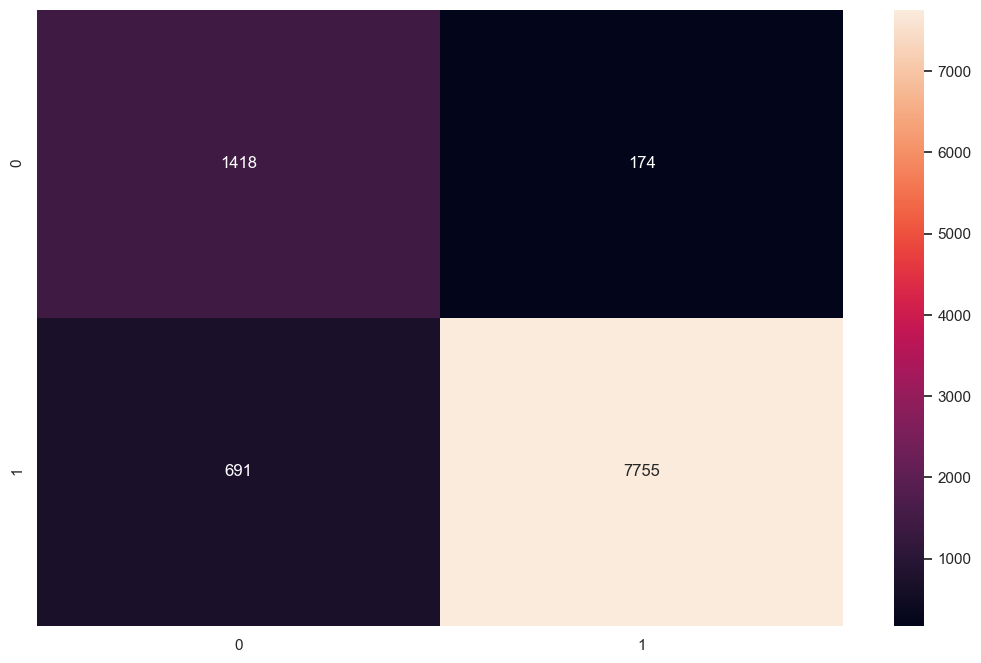

In [73]:
from sklearn.model_selection import GridSearchCV, KFold

rf_param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Then we run our pipeline and train the model
pipeline3 = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
])

cv = KFold(n_splits=5, shuffle=True, random_state=23)

rf_grid_search = GridSearchCV(estimator=pipeline3,
                              param_grid=rf_param_grid,
                              scoring='accuracy',
                              cv=cv,
                              verbose=2, n_jobs=-1)

rf_grid_pipe = rf_grid_search.fit(X_train2, y_train2)

# Evaluation on original data
predictions3 = rf_grid_pipe.predict(X_test)
Performance(y_test, predictions3)
sns.heatmap(confusion_matrix(y_test, predictions3), annot=True, fmt='')

In [53]:
print("Best Hyperparameters:", rf_grid_pipe.best_params_)
y_pred = rf_grid_pipe.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))

NameError: name 'rf_grid_pipe' is not defined

In [92]:
vect = CountVectorizer(stop_words="english", max_features=4000)
text = vect.fit("Hi")

ValueError: Iterable over raw text documents expected, string object received.

In [88]:
X_new_counts = trf.transform("HI")

ValueError: Iterable over raw text documents expected, string object received.